# Retrieving Simulator Logs from Log Analytics for Analysis

This notebook shows you how to access the logs from your simulators, and provides a few sample analyses. Episode level and iteration level logs during training and assessment are stored on [Log Anlytics](https://docs.microsoft.com/en-us/azure/azure-monitor/platform/data-platform-logs). The logs on Azure Monitor can be accessed using the query language [KQL](https://docs.microsoft.com/en-us/sharepoint/dev/general-development/keyword-query-language-kql-syntax-reference). 

The notebook uses the jupyter extension [`Kqlmagic`](https://github.com/Microsoft/jupyter-Kqlmagic), to automatically query the data directly within the notebook. More info + more complete functionality on the ` Kqlmagic` extension is available on its official [docs](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic).

## Description

Simulator logs are enabled by default for brains trained during assessment. For training they must be enabled via the CLI command [bonsai brain version start-logging](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-logging).

## Prerequisites

1. Install requirements: an [enviroment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/) is provided with a complete description of the packages needed to run this notebook using Anaconda. Please install Anaconda (or miniconda) and run `conda env update -f environment.yml` in the folder where you download the linked `environment.yml` file.
2. If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered manually using the azure-cli:
    1. Determine if registering is required. <SUBCRIPTION_ID> can be found on preview.bons.ai by clicking on id/Workspace info. 
    ```
    az provider show --namespace 'Microsoft.OperationalInsights' -o table --subscription <SUBCRIPTION_ID>
    ```
    2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace 'Microsoft.OperationalInsights' --subscription <SUBCRIPTION_ID>
    ```
### Note

A Log Analytics workspace will get created on Azure if it does not already exist in the provisioned Bonsai workspace.
 
## Usage

1. Start a simulator instance for Brain training: 
    1. For managed simulators
        1. Add the simulator instance to your inkling using the `package` statement, or start training and select the simulator instance using the web
        2. _or_ use the CLI: [`bonsai brain version start-training --simulator-package-name`](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-training)
    2. For unmanaged simulators:
        1. register a sim by launching your sim. For example `python main.py`
        2. start brain training `bonsai brain version start-training --name <BRAIN_NAME>`
        3. connect your registered sim to a brain `bonsai simulator unmanaged connect --simulator-name <SIM_NAME> --brain-name <BRAIN_NAME> --version <VERSION_#> --action Train --concept-name <CONCEPT_NAME>`
        4. Find the `session-id` of un-managed sim using Bonsai CLI: `bonsai simulator unmanaged list`
2. Enable logging using the CLI:
    1. For managed simulators, add the `-m` parameter for managed simulator logging and the number of instances to log:
        `bonsai brain version start-logging -m -s <NUM_INSTANCES> -n <BRAIN_NAME>`
        You can also optionally request for system logs with the `-l` parameter.
    2. For unmanaged simulators, you should specify the `session-id`: 
        `bonsai brain version start-logging -n <BRAIN_NAME> --session-id <SESSION_ID>`
3. Logs will start populating the Log Analytics workspace 3-5 minutes after starting logging
4. Obtain your KQL workspace-id by navigating to the KQL resource in the Azure Portal:
    ![log-analytics-azure-portal](log-analytics-id.png)

## Getting Started

### Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statem `%%kql`.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


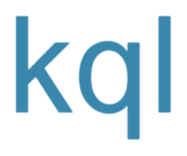

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

### Login to the log analytics workspace

Retrieve the `LOG_ANALYTICS_WORKSPACE_ID` using the instructions provided above. Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace!


In [2]:
LOG_ANALYTICS_WORKSPACE_ID = ""
ALIAS = 'jomcdowe' # could be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

## Iteration and Episode Level Logs

There are four tables generated by the Bonsai service and sent to your Log Analytics workspace. These are:

1. `EpisodeLog_CL` which contains your episode-level logs, such as information about the starting simulator configuration of your episodes, your aggregate goal metrics, etc.
2. `IterationLog_CL` which contains the interation-level logs of your simulator, including the actions received from the platform, and the states emitted from your simulators.
3. `ContainerEvent_CL` (**only for managed simulators that were logged with system logs**): container event logs such as image pull time, build time, etc.
4. `ContainerInstanceLog_CL` (**only for managed simulators that were logged with system logs**): system logs from your simulators.

Let's extract both iteration (`IterationLog_CL`) and episode-level (`EpisodeLog_CL`) logs and join them together via a KQL query. We then export the query results to a pandas dataframe which we can then manipulate and analyze.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level logs are created and filled with at least 1 row of data.

### Specify Query Variables and Query

In order to make our query specific to a brain version and brain name, we can create variables containing those values. The following cell does exactly that, and in addition specific a max number of rows to query.

<div class="alert alert-block alert-danger">
<b>WARNING: KQL queries are case-sensitive and the data stored in your analytics workspace is saved as lowercase strings. Brain name and assessment name must be set as lowercase or the query options noted below will fail to find any data.
</div>

In [3]:
number_of_rows = 100000
brain_name = "scg-fun".lower()
brain_version = 23

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` table to the brain name and brain version we defined above, and then join it with the `IterationLog_CL` table using the unique `EpisodeId_g` index. Finally, we select (using `project`) a set of columns we want to retain in our resulting dataframe.

In [4]:
%%kql
let _number_of_rows = number_of_rows;
let _brain_name = brain_name;
let _brain_version = brain_version;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(60d)
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
  | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by SessionIndex, EpisodeIndex asc, IterationIndex asc

<IPython.core.display.Javascript object>

[{'Timestamp': datetime.datetime(2021, 9, 20, 6, 59, 49, 8000, tzinfo=tzutc()), 'SessionIndex': '1571093053_10.244.93.164', 'EpisodeIndex': 1, 'IterationIndex': 4, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 23, 'SimState': {'deltaMI_201': 1.50887154660672, 'deltaMI_201_past': 1.634221939940053, 'deltaMI_221': 0.916580863932524, 'deltaMI_221_past': -0.012384136067476126, 'C2': 0, 'BR_201': 0, 'BR_221': 0, 'Density_221': -0.34618181818182203, 'current_H2_201': 0.8832215792084168, 'current_H2_221': 0.3068802259901365, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 1.036, 'reward_value': 0.7450964004359419, 'terminal_value': False}, 'SimAction': {'H2_201': 0.7457213997840881, 'H2_221': 0.16778911650180817}, 'SimConfig': {}, 'Reward': 0.745096400435942, 'CumulativeReward': 15.0121412277222, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 9, 20, 7, 3, 41, 795000, tzinfo=tzutc()), 'SessionIndex': '1571093053_10.244.93.164', 'EpisodeIndex': 1, 'IterationIndex': 5, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 23, 'SimState': {'deltaMI_201': 1.480359539940053, 'deltaMI_201_past': 1.50887154660672, 'deltaMI_221': 3.985358863932525, 'deltaMI_221_past': 0.916580863932524, 'C2': 0, 'BR_201': 0, 'BR_221': 0, 'Density_221': -0.30163636363637836, 'current_H2_201': 0.9944835629209312, 'current_H2_221': 0.518194129321893, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 1.1567142857142858, 'reward_value': 0.49234796751409193, 'terminal_value': False}, 'SimAction': {'H2_201': 0.3337859511375427, 'H2_221': 0.6339417099952698}, 'SimConfig': {}, 'Reward': 0.492347967514092, 'CumulativeReward': 15.0121412277222, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 9, 20, 7, 3, 41, 836000, tzinfo=tzutc()), 'SessionIndex': '1571093053_10.244.93.164', 'EpisodeIndex': 1, 'IterationIndex': 6, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 23, 'SimState': {'deltaMI_201': 1.480359539940053, 'deltaMI_201_past': 1.480359539940053, 'deltaMI_221': 3.985358863932525, 'deltaMI_221_past': 3.985358863932525, 'C2': 0, 'BR_201': 0, 'BR_221': 0, 'Density_221': -0.30163636363637836, 'current_H2_201': 1, 'current_H2_221': 0.4472676220078468, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 1.1567142857142858, 'reward_value': 0.49234796751409193, 'terminal_value': False}, 'SimAction': {'H2_221': -0.21277952194213867, 'H2_201': 0.3148995041847229}, 'SimConfig': {}, 'Reward': 0.492347967514092, 'CumulativeReward': 15.0121412277222, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 9, 20, 7, 3, 41, 869000, tzinfo=tzutc()), 'SessionIndex': '1571093053_10.244.93.164', 'EpisodeIndex': 1, 'IterationIndex': 7, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 23, 'SimState': {'deltaMI_201': 1.480359539940053, 'deltaMI_201_past': 1.480359539940053, 'deltaMI_221': 3.985358863932525, 'deltaMI_221_past': 3.985358863932525, 'C2': 0, 'BR_201': 0, 'BR_221': 0, 'Density_221': -0.30163636363637836, 'current_H2_201': 1, 'current_H2_221': 0.19558667168410615, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 1.1567142857142858, 'reward_value': 0.49234796751409193, 'terminal_value': False}, 'SimAction': {'H2_201': 0.19267573952674863, 'H2_221': -0.7550428509712219}, 'SimConfig': {}, 'Reward': 0.492347967514092, 'CumulativeReward': 15.0121412277222, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2021, 9, 20, 7, 7, 16, 951000, tzinfo=tzutc()), 'SessionIndex': '1571093053_10.244.93.164', 'EpisodeIndex': 1, 'IterationIndex': 8, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fu

### Magic

Magically, the output of the result is saved to a new python variable called `_kql_raw_result`. We can convert this to a pandas dataframe:

In [5]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

Timestamp              SessionIndex  EpisodeIndex  \
0 2021-09-20 06:59:49.008000+00:00  1571093053_10.244.93.164           1.0   
1 2021-09-20 07:03:41.795000+00:00  1571093053_10.244.93.164           1.0   
2 2021-09-20 07:03:41.836000+00:00  1571093053_10.244.93.164           1.0   
3 2021-09-20 07:03:41.869000+00:00  1571093053_10.244.93.164           1.0   
4 2021-09-20 07:07:16.951000+00:00  1571093053_10.244.93.164           1.0   

   IterationIndex EpisodeType_s BrainName  BrainVersion  \
0             4.0      Training   scg-fun          23.0   
1             5.0      Training   scg-fun          23.0   
2             6.0      Training   scg-fun          23.0   
3             7.0      Training   scg-fun          23.0   
4             8.0      Training   scg-fun          23.0   

                                            SimState  \
0  {'deltaMI_201': 1.50887154660672, 'deltaMI_201...   
1  {'deltaMI_201': 1.480359539940053, 'deltaMI_20...   
2  {'deltaMI_201': 1.480359539940053, 'deltaMI_20...   
3  {'deltaMI_201': 1.480359539940053, 'deltaMI_20...   
4  {'deltaMI_201': 1.2336271399400531, 'deltaMI_2...   

                                           SimAction SimConfig    Reward  \
0  {'H2_201': 0.7457213997840881, 'H2_221': 0.167...        {}  0.745096   
1  {'H2_201': 0.3337859511375427, 'H2_221': 0.633...        {}  0.492348   
2  {'H2_221': -0.21277952194213867, 'H2_201': 0.3...        {}  0.492348   
3  {'H2_201': 0.19267573952674863, 'H2_221': -0.7...        {}  0.492348   
4  {'H2_221': -0.08016017824411392, 'H2_201': -0....        {}  0.813793   

   CumulativeReward  Terminal  LessonIndex GoalMetrics EpisodeType  \
0         15.012141     False          0.0          {}    Training   
1         15.012141     False          0.0          {}    Training   
2         15.012141     False          0.0          {}    Training   
3         15.012141     False          0.0          {}    Training   
4         15.012141     False          0.0          {}    Training   

  FinishReason  
0  Interrupted  
1  Interrupted  
2  Interrupted  
3  Interrupted  
4  Interrupted

## Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [6]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])


In [7]:
df = format_kql_logs(iter_df)

In [8]:
df.sort_values(by=["EpisodeIndex", "IterationIndex"])

Timestamp  EpisodeIndex  IterationIndex  \
35776 2021-09-20 14:06:24.905000+00:00           1.0             1.0   
39027 2021-09-20 15:06:20.494000+00:00           1.0             1.0   
39028 2021-09-20 15:06:20.507000+00:00           1.0             1.0   
39029 2021-09-20 15:06:20.518000+00:00           1.0             1.0   
39030 2021-09-20 15:06:20.729000+00:00           1.0             1.0   
39031 2021-09-20 15:06:20.753000+00:00           1.0             1.0   
39032 2021-09-20 15:06:20.796000+00:00           1.0             1.0   
39033 2021-09-20 15:06:20.955000+00:00           1.0             1.0   
39034 2021-09-20 15:06:20.995000+00:00           1.0             1.0   
39035 2021-09-20 15:06:21.006000+00:00           1.0             1.0   
39036 2021-09-20 15:06:21.173000+00:00           1.0             1.0   
39037 2021-09-20 15:06:21.631000+00:00           1.0             1.0   
39038 2021-09-20 15:06:22.048000+00:00           1.0             1.0   
39039 2021-09-20 15:06:27.244000+00:00           1.0             1.0   
39040 2021-09-20 15:06:30.941000+00:00           1.0             1.0   
39041 2021-09-20 15:06:31.133000+00:00           1.0             1.0   
39042 2021-09-20 15:06:31.149000+00:00           1.0             1.0   
39043 2021-09-20 15:06:31.268000+00:00           1.0             1.0   
39044 2021-09-20 15:06:31.465000+00:00           1.0             1.0   
39045 2021-09-20 15:06:32.439000+00:00           1.0             1.0   
39046 2021-09-20 15:06:39.102000+00:00           1.0             1.0   
39047 2021-09-20 15:06:41.252000+00:00           1.0             1.0   
39048 2021-09-20 15:06:41.734000+00:00           1.0             1.0   
39049 2021-09-20 15:06:41.915000+00:00           1.0             1.0   
39050 2021-09-20 15:06:42.024000+00:00           1.0             1.0   
39051 2021-09-20 15:06:42.136000+00:00           1.0             1.0   
39052 2021-09-20 15:06:42.143000+00:00           1.0             1.0   
39053 2021-09-20 15:06:42.243000+00:00           1.0             1.0   
39054 2021-09-20 15:06:42.315000+00:00           1.0             1.0   
39055 2021-09-20 15:06:42.387000+00:00           1.0             1.0   
...                                ...           ...             ...   
92254 2021-09-21 02:01:52.482000+00:00          44.0             1.0   
90146 2021-09-21 01:34:01.437000+00:00          44.0             2.0   
92339 2021-09-21 02:03:36.054000+00:00          44.0             2.0   
90253 2021-09-21 01:35:15.405000+00:00          44.0             3.0   
92401 2021-09-21 02:04:57.852000+00:00          44.0             3.0   
90359 2021-09-21 01:36:35.377000+00:00          44.0             4.0   
92444 2021-09-21 02:06:06.824000+00:00          44.0             4.0   
90372 2021-09-21 01:36:44.012000+00:00          45.0             1.0   
90492 2021-09-21 01:38:10.910000+00:00          45.0             2.0   
90614 2021-09-21 01:39:35.342000+00:00          45.0             3.0   
90721 2021-09-21 01:41:00.391000+00:00          45.0             4.0   
90838 2021-09-21 01:42:23.145000+00:00          45.0             5.0   
90927 2021-09-21 01:43:44.396000+00:00          45.0             6.0   
91066 2021-09-21 01:45:13.474000+00:00          45.0             7.0   
91193 2021-09-21 01:46:45.298000+00:00          45.0             8.0   
91284 2021-09-21 01:48:07.615000+00:00          45.0             9.0   
91298 2021-09-21 01:48:15.929000+00:00          46.0             1.0   
91409 2021-09-21 01:49:45.011000+00:00          46.0             2.0   
91534 2021-09-21 01:51:17.254000+00:00          46.0             3.0   
91640 2021-09-21 01:52:43.738000+00:00          46.0             4.0   
91729 2021-09-21 01:54:09.090000+00:00          46.0             5.0   
91840 2021-09-21 01:55:34.607000+00:00          46.0             6.0   
91850 2021-09-21 01:55:43.033000+00:00          47.0             1.0   
91936 2021-09-21 01:57:03.362000+00:00          47.0             2.0 

In [20]:
cols_tv = [
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'H2_201',
    'H2_221',
    'reward_value',
    'terminal_value',
    #'Density_221',
    #'MI_201',
    #'MI_221',
    #'C2',
    #'BR_201',
    #'BR_221',
    #'step_count',
    #'sim_action_H2_201',
    #'sim_action_H2_221',
    #'sim_action_C2',
    #'sim_action_C4_241',
    #'sim_action_C4_221',
    #'sim_action_BR_201',
    #'sim_action_BR_241',
    #'sim_action_BR_221',
]
df[cols_tv].describe()

deltaMI_201   deltaMI_221  current_H2_201  current_H2_221  \
count  92521.000000  92521.000000    92521.000000    92521.000000   
mean       0.505479     -0.475559        0.463994        0.187754   
std        0.786149      0.986018        0.201198        0.129878   
min       -0.978638     -1.560527        0.000000        0.000000   
25%       -0.013891     -1.214482        0.331985        0.072802   
50%        0.166115     -0.766545        0.447245        0.189369   
75%        0.737054     -0.048140        0.555260        0.274354   
max        3.346661     13.432559        1.000000        1.000000   

       deltaPressure        H2_201        H2_221  reward_value  
count   92521.000000  85534.000000  85534.000000  92521.000000  
mean        0.595889     -0.017340      0.007424      2.381362  
std         0.202178      0.437142      0.440221      7.894663  
min        -0.154143     -1.000000     -1.000000     -1.000000  
25%         0.466714     -0.309799     -0.292217      0.785403  
50%         0.589286     -0.015052      0.006663      0.834047  
75%         0.704571      0.277268      0.309469      0.909980  
max         1.159714      1.000000      1.000000     55.500000

# Convert to NeuralSim Dev tool

In [10]:
import os
import numpy as np
import random

isdir = os.path.isdir("training")
if isdir:
    pass
else:
    os.makedirs("training")
    
isdir = os.path.isdir("validation")
if isdir:
    pass
else:
    os.makedirs("validation")

In [11]:
cols = [
    'EpisodeIndex',
    'IterationIndex',
    'Terminal',
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'reward_value',
    'terminal_value',
    'H2_201',
    'H2_221',
]

state_cols = [
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'reward_value',
    'terminal_value'
]

action_cols = [
    'H2_201',
    'H2_221',
]

config_cols = [
]

for sess in iter_df['SessionIndex'].unique():
#for sess in ['149204247_10.244.8.228']:
    print("doing sess {}".format(sess))
    df_session = iter_df[iter_df['SessionIndex'] == sess]
    df_session = format_kql_logs(df_session)
    df_session.sort_values(by=["EpisodeIndex", "IterationIndex"])
    for ep in range(1, int(max(df_session['EpisodeIndex']))+1):
    #for ep in range(5, 6):
        print("doing ep {}".format(ep))
        df_flat = df_session[df_session['EpisodeIndex'] == ep]
        if len(df_flat) > 1:
            if df_flat['IterationIndex'].iloc[1] == 1:
                print('Truncating ep because duplicate')
            elif df_flat['IterationIndex'].iloc[0] == 1:
                df_flat = df_flat[cols]
                df_flat['terminal_value'] = df_flat['terminal_value'].map(int)
                df_ep = pd.DataFrame({})
                df_ep['EpisodeIndex'] = '"' + sess + '_ep_' +df_flat['EpisodeIndex'].map(str) + '"'
                df_ep['IterationIndex'] = df_flat['IterationIndex'].astype(int)
                df_ep['is_initial_state'] = df_flat.eval("IterationIndex == 1")
                df_ep['is_terminal_state'] = df_flat['Terminal']
                df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(True, 'true')
                df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(False, 'false')
                df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(True, 'true')
                df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(False, 'false')
                df_ep['state'] = df_flat[state_cols].to_numpy().tolist()
                df_ep['action'] = df_flat[action_cols].to_numpy().tolist()
                df_ep['action'].iloc[0] = []
                df_ep['config'] = df_flat[config_cols].to_numpy().tolist()
                # since empty config, need 0
                df_ep['config'] = df_ep['config'].apply(lambda x: x if x else 0)
                if np.random.uniform(0, 1) <= 0.1:
                    df_ep.to_csv('./validation/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)
                else:
                    df_ep.to_csv('./training/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)
            else:
                print('Truncating ep because did not start at IterationIndex=1')
        else:
            print('Empty episode')

doing sess 1571093053_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571092964_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571092731_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5
Empty episode
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571092212_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1571092110_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571089479_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
Empty episode
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571085925_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571084821_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1571083306_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571081973_10.244.93.164
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8
Empty episode
doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571079902_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571078387_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571078312_10.244.93.164
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571077596_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571077175_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1571077050_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571075325_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571073564_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571073526_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571071329_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
Empty episode
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571070616_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571066125_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1571065790_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571064148_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571059285_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing sess 1571057845_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571055800_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571053002_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571050598_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571046312_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571044516_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571042184_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571041044_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1571040354_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Truncating ep because did not start at IterationIndex=1
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571040139_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571036088_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571035532_10.244.93.164
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571035257_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571034836_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1571033040_10.244.93.164
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554638213_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554635759_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554632797_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554629696_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554627397_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554624535_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554615091_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554609860_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554608755_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16
doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554604552_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554603500_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554599190_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554597762_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554595508_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554592798_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554589657_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554587733_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1554581706_10.244.92.169
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529413043_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529407841_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529400766_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529399389_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 43


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 44


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529399121_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529398640_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12
doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529392259_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529391692_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529391421_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529389650_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529386826_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529385120_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529384923_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529381790_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529364130_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529363846_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529352434_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1529350253_10.244.91.40
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511124744_10.244.90.17
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511122413_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511118905_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15
Empty episode
doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511118674_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511117592_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511115984_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511115312_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1511115004_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511113885_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511113795_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
Empty episode
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511112626_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511112506_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511109538_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511109055_10.244.90.17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511109004_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1511107697_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511103735_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511103002_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511101650_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511100882_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511098638_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511096065_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511095100_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511094077_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511093050_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511092996_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511092167_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5
Empty episode
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511090271_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511089745_10.244.90.17
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511089154_10.244.90.17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511085899_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1511084644_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1511083698_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing sess 1511082912_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511081680_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511081275_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511080627_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4
Empty episode
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6
Empty episode
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511079687_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511078673_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511076766_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511074525_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511069798_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511069361_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511068397_10.244.90.17
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1511066178_10.244.90.17
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1499919247_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499918427_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1499915403_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499914631_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499913431_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499911803_10.244.89.102
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499911390_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499910757_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499909762_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5
Empty episode
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499908789_10.244.89.102
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499906432_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499905389_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499904426_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499901041_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499899621_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499898321_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499894576_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1499894245_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499893367_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499887122_10.244.89.102
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499879883_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499878998_10.244.89.102
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4
Empty episode
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499876789_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13
Empty episode
doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499871537_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499870646_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499868106_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499861928_10.244.89.102
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1499861609_10.244.89.102
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149213491_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17
doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149211870_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149205934_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149204247_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5
Truncating ep because duplicate
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149203475_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149197233_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149197229_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149194883_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11
Truncating ep because duplicate
doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149189432_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149181143_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149174919_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149165419_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149164353_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 149160735_10.244.8.228
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489957693_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489954716_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18
Empty episode
doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489951518_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1489950797_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16
Empty episode
doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489948742_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489948604_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489948230_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489947314_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489946107_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489944020_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489940483_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489939475_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9
Empty episode
doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489937078_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10
Empty episode
doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489936245_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489933458_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489932361_10.244.88.206
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489929459_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1489928267_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489927937_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489920543_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489919807_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1489917885_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489916131_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11
Empty episode
doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489912614_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489911656_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Empty episode
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8
Empty episode
doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489910770_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6
Empty episode
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489910350_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489909732_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10
doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489909094_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489908191_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489907667_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489903850_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489903307_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4
Empty episode
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489902429_10.244.88.206
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489896894_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1489896407_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11
Empty episode
doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1489896342_10.244.88.206
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480259440_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480259290_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480254150_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480252773_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14
Truncating ep because duplicate
doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480242811_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480241267_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480239818_10.244.88.58
doing ep 1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480236070_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16
Truncating ep because duplicate
doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480229533_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480228976_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480224591_10.244.88.58
doing ep 1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480216716_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480213151_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480212563_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480209642_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480207386_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480204193_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480203549_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480199490_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480199012_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1480196443_10.244.88.58
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 43


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145489556_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145488875_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145488786_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 145488444_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145485809_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145485584_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11
Empty episode
doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145485350_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145483391_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145482355_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145477660_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145472350_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145468161_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145467991_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10
Empty episode
doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145460963_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145460844_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145456474_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145456063_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145455487_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12
Empty episode
doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145455140_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145454758_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145454182_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145452566_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145451457_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9
Empty episode
doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145451284_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 145447592_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145445796_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145444255_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing sess 145440349_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145436599_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145436165_10.244.8.171
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 145430016_10.244.8.171
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 145426261_10.244.8.171
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431169117_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431162443_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431153944_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431151236_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431144311_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23
doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431144182_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431141745_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431140997_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431137822_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431137140_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431136721_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431133583_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431133082_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431129948_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431129743_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431129090_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431128497_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431128035_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431125849_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431123595_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431122415_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431121630_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 43


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431120672_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431115565_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431115271_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431113674_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1431111018_10.244.85.77
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428813491_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428813154_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428811954_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428806497_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428805244_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1428801997_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428800738_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428799965_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5
Empty episode
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9
Empty episode
doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18
Empty episode
doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428798647_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428794733_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428794312_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428794098_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428793013_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13
Empty episode
doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428791938_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428790296_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1428784896_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1428784862_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428784344_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428781209_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428780735_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428778948_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing sess 1428776006_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428773636_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428769595_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428768300_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428767422_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428766823_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428766104_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428766071_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1428764578_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428761992_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428759615_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428759028_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428754705_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11
Empty episode
doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428754326_10.244.85.41
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1428751565_10.244.85.41
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1312619252_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312617775_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312613195_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312611070_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312610698_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312610591_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312608167_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312606437_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312606067_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312595930_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312594465_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312593644_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312593271_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312592094_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9
doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312588941_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312586922_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312584214_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312583375_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312579586_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312579171_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312578985_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312574474_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312574083_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312573352_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312569565_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312566806_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312561717_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1312557935_10.244.78.60
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293746162_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19
Empty episode
doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293743875_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293740453_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293739783_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13
Empty episode
doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293735858_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1293734829_10.244.77.28
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8
Empty episode
doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293734177_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Empty episode
doing ep 6
Truncating ep because did not start at IterationIndex=1
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293728888_10.244.77.28
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10
Empty episode
doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293726059_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293723551_10.244.77.28
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293723151_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Truncating ep because did not start at IterationIndex=1
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293722723_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1293721301_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293717968_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293716049_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293715337_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1293713429_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1293712907_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293711077_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293710510_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293709162_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293707729_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293706308_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7
Empty episode
doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293703194_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293702954_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293702151_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1293698985_10.244.77.28
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293698564_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293695392_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293686033_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293685956_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293685908_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1293685082_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1293684048_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1293682676_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12
Empty episode
doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293682463_10.244.77.28
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1293682334_10.244.77.28
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10
Truncating ep because duplicate
doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283980141_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283979241_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283977545_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1283976289_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1283975370_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Truncating ep because did not start at IterationIndex=1
doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283967118_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing sess 1283966740_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283965124_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283959636_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing sess 1283954667_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283953358_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283949970_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1283947304_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283946729_10.244.76.135
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9
Empty episode
doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283945135_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283943729_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283943607_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14
Empty episode
doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283938465_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Truncating ep because did not start at IterationIndex=1
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283935339_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283934703_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283931968_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283931891_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Truncating ep because did not start at IterationIndex=1
doing ep 3
Empty episode
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283928968_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Empty episode
doing ep 4
Empty episode
doing ep 5
Truncating ep because did not start at IterationIndex=1
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283928526_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283927576_10.244.76.135
doing ep 1
Empty episode
doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1283919065_10.244.76.135
doing ep 1
Truncating ep because did not start at IterationIndex=1
doing sess 1283917183_10.244.76.135
doing ep 1
Empty episode
doing ep 2
Empty episode
doing ep 3
Truncating ep because did not start at IterationIndex=1
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145569043_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145568023_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145566090_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17
doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145561004_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145559173_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 34


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 35


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 36


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 37


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 38


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 39


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 40


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 41


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 42


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 43


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 44


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 45


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 46


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 47


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145556182_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145555845_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3
doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145552898_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145552417_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5
doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145552162_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145540993_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145534737_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145531927_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145530591_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145525969_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145522910_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145521087_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145515411_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145514686_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145512036_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145509382_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1145506239_10.244.68.71
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 32


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 33


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131472374_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131471470_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131464506_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131456969_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131456719_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131454254_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131441325_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131431996_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131430104_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131425957_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131425731_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 31


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131421646_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 28


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 29


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 30


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing sess 1131414735_10.244.67.112
doing ep 1


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 2


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 3


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 4


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 5


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 6
Truncating ep because duplicate
doing ep 7


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 8


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 9


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 10


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 11


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 12


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 13


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 14


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 15


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 16


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 17


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 18


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 19


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 20


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 21


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 22


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 23


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 24


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 25


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 26


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



doing ep 27


C:\Users\JOMCDOWE\Miniconda3\envs\bonsai-preview\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Distributions of values 

In [ ]:
 plot_df = df.pivot_table(
     index=['IterationIndex'], 
     values= ['angle_position','angle_velocity', 'x_position','x_velocity']
    )
plot_df.plot(kind='hist',alpha=0.5)

## Iteration speed

In [ ]:
plotdf = df
plotdf.index= df['Timestamp']
plotdf.iplot(
    subplots=True,
    shared_xaxes=True,
    title = 'vs Timestamp'
    )

plotdf['IterationSpeed_s'].iplot(
    title = 'IterationSpeed distribution',
    kind='hist',
    xTitle='IterationSpeed_s',
    yTitle='Count'
    )

## State trajectory for multiple episodes
TODO: Consider plotting considering vs SimConfig

In [ ]:
plot_df = df.pivot(
    index=['IterationIndex'],
    columns = ['EpisodeIndex'],
    values = ['x_position', 'angle_position','x_velocity','angle_velocity'])
plot_df.head(10)

## Retrieving Logs for Assessment

Here is an example of extracting logs that were generated during assessment. We modify our above query by including the `AssessmentId_g` column, and filter only for those that were not empty, which should be when the simulators were being used for assessment:

In [ ]:
brain_name = "cartpole-assessment-test".lower()

In [ ]:
%%kql
let _number_of_rows = 1000;
let _brain_name = brain_name;
let _brain_version = 2;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(30d)
  | where AssessmentId_g != ""
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
//   | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      AssessmentName = AssessmentName_s,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by AssessmentName, SessionIndex, EpisodeIndex asc, IterationIndex asc

In [ ]:
assess_df = _kql_raw_result_.to_dataframe()

In [ ]:
assess_df.describe()